### **SIMPLE MODEL**
**Our model will work like this:**
 - **We use GW variables from the period t-13 to t-2 to explain ERP for the period t-1.**
 - **The signal s_t, i.e., the forecast of ERP for period t, is based on GW variables from period t-1 and parameters estimated over the window t-13 to t-2 (eliminating lookahead bias).**
 - **The timing strategy has a return in period t given by s_t * ERP_t.**


In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from tqdm import tqdm
import statsmodels.api as sm
from scipy.stats import skew

print(os.getcwd())
predictors = pd.read_excel("predictors.xlsx")
dependent_vars = pd.read_excel("dependent_vars.xlsx")
risk_free_rate = pd.read_excel('risk_free_rate.xlsx')

c:\Users\jsmig\OneDrive\Desktop\MASTERS


In [148]:
predictors['date'] = pd.to_datetime(predictors['yyyymm'], format='%Y%m')
predictors = predictors.drop(columns = ['yyyymm'])
predictors.set_index('date', inplace=True)

dependent_vars['date'] = pd.to_datetime(dependent_vars['DATE'], format='%Y%m')
dependent_vars = dependent_vars.drop(columns = ['DATE'])
dependent_vars.set_index('date', inplace=True)

risk_free_rate['date'] = pd.to_datetime(risk_free_rate['yyyymm'], format='%Y%m')
risk_free_rate = risk_free_rate.drop(columns = ['yyyymm'])
risk_free_rate.set_index('date', inplace=True)

In [149]:
def rolling_signal_strategy(predictors, target_series, target_name):
    window_size = 12
    linear_model = Ridge(alpha=0, solver='svd')
    signals = []

    for t in tqdm(range(window_size + 2, len(target_series))):
        X_window = predictors.iloc[t - window_size - 1 : t - 1]  # t-13 : t-2
        y_window = target_series.iloc[t - window_size : t] # t-12 : t-1

        linear_model.fit(X_window.values, y_window.values)

        past_predictors = predictors.iloc[t - 1:t]  # t-1
        predicted_return = linear_model.predict(past_predictors.values)[0]

        actual_return = target_series.iloc[t]
        strategy_return = predicted_return * actual_return

        signals.append({
            'date': target_series.index[t],
            'predicted return': predicted_return,
            f'{target_name}': actual_return,
            'strategy return': strategy_return
        })

    return pd.DataFrame(signals).set_index('date')

In [150]:
def sharpe_ratio(series):
    mean_return_annualized = series.mean() * 12
    std_annualized = series.std(ddof=1) * np.sqrt(12)
    sharpe_ratio = (mean_return_annualized) / std_annualized
    print(f'Sharpe Ratio: {sharpe_ratio}')

    return sharpe_ratio

def skewness(series):
    #mean = series.mean()
    #median = series.median()
    #skewness = (3 * (mean-median))/ np.std(series)
    skewness = skew(series, bias=False)
    print(f'Skewness: {skewness}')
    
    return skewness


In [151]:
predictors

,dfy,infl,svar,d/e,lty,tms,tbl,corpr,d/p,d/y,ltr,e/p,b/p,ntis,lag_ret
date,,,,,,,,,,,,,,,
1927-01-01,0.0095,-0.011299,0.000470,0.566884,0.0351,0.0028,0.0323,0.005600,0.052740,0.051646,0.007500,0.093036,2.253746,0.050824,0.026047
1927-02-01,0.0092,-0.005714,0.000287,0.577422,0.0347,0.0018,0.0329,0.006900,0.050816,0.053240,0.008800,0.088006,2.333718,0.051668,-0.002910
1927-03-01,0.0092,-0.005747,0.000924,0.587748,0.0331,0.0011,0.0320,0.008300,0.050969,0.051301,0.025300,0.086719,2.128723,0.046357,0.045522
1927-04-01,0.0090,0.000000,0.000603,0.598747,0.0333,-0.0006,0.0339,0.005500,0.050579,0.051450,-0.000500,0.084474,2.189362,0.050514,0.007324
1927-05-01,0.0093,0.005780,0.000392,0.609865,0.0327,-0.0006,0.0333,-0.001100,0.048511,0.051044,0.010900,0.079544,2.300000,0.055275,0.013021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-01,0.0107,0.004367,0.001337,0.377320,0.0417,-0.0113,0.0530,-0.007769,0.015333,0.015061,-0.005182,0.040635,4.741925,-0.016514,0.031700
2023-09-01,0.0103,0.002485,0.001023,0.376191,0.0438,-0.0094,0.0532,-0.026694,0.016164,0.015377,-0.022094,0.042968,4.576075,-0.017989,-0.015424
2023-10-01,0.0102,-0.000383,0.001678,0.372471,0.0480,-0.0054,0.0534,-0.018726,0.016606,0.016241,-0.012083,0.044584,4.513986,-0.014711,-0.047566


In [152]:
dependent_vars

,HML,GS10,RET
date,,,
1927-01-01,4.54,NaN,-0.002910
1927-02-01,2.94,NaN,0.045522
1927-03-01,-2.61,NaN,0.007324
1927-04-01,0.81,NaN,0.013021
1927-05-01,4.73,NaN,0.062353
...,...,...,...
2023-08-01,-1.08,4.17,-0.015424
2023-09-01,1.45,4.38,-0.047566
2023-10-01,0.19,4.80,-0.021040


In [153]:
risk_free_rate

,Rfree
date,
1927-01-01,0.0025
1927-02-01,0.0026
1927-03-01,0.0030
1927-04-01,0.0025
1927-05-01,0.0030
...,...
2023-08-01,0.0045
2023-09-01,0.0043
2023-10-01,0.0047


In [154]:
rfr = risk_free_rate['Rfree']
rfr = rfr['1927-01-01':'2020-12-01']

market_return = dependent_vars['RET']
market_return = market_return['1927-01-01':'2020-12-01']

HML = dependent_vars['HML']
HML = HML['1927-01-01':'2020-12-01']

### **Excess Market Return**

In [155]:
market_return_predictors = predictors['1927-01-01':'2020-12-01'] 
market_return = market_return - rfr

In [156]:
market_signals = rolling_signal_strategy(market_return_predictors,market_return,'Equity Market Return')

100%|██████████| 1114/1114 [00:00<00:00, 1245.24it/s]


In [157]:
market_signals

,predicted return,Equity Market Return,strategy return
date,,,
1928-03-01,-0.031444,0.102852,-0.003234
1928-04-01,0.130621,0.032525,0.004248
1928-05-01,0.104944,0.009125,0.000958
1928-06-01,-0.402334,-0.037430,0.015059
1928-07-01,0.088418,0.006917,0.000612
...,...,...,...
2020-08-01,-0.133414,0.071968,-0.009602
2020-09-01,0.201061,-0.038251,-0.007691
2020-10-01,-0.036871,-0.026509,0.000977


**Equity Market Performance Measures**

In [158]:
market_sr = sharpe_ratio(market_signals['Equity Market Return'])
market_skew = skewness(market_signals['Equity Market Return'])

Sharpe Ratio: 0.42297742477606753
Skewness: 0.38433807908225176


**Equity Market Simple Model Performance Measures**

In [159]:
market_simple_sr = sharpe_ratio(market_signals['strategy return'])
market_simple_skew = skewness(market_signals['strategy return'])

Sharpe Ratio: 0.031649203728011964
Skewness: -5.210380376041327


In [160]:
y = market_signals['strategy return']
X = market_signals['Equity Market Return']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

alpha = model.params['const']

residuals = model.resid

tracking_error = residuals.std()

market_simple_app_ratio  = alpha / tracking_error
market_simple_alpha_t_stat  = model.tvalues['const']

In [161]:
data_market = {
    'US Stocks Excess Return': [market_sr, None, None, market_skew],
    'Simple Linear Timing Strategy Return': [
        market_simple_sr,
    market_simple_app_ratio,
    market_simple_alpha_t_stat,
    market_simple_skew
    ]
}
index = ['Sharpe Ratio', 'Appraisal Ratio', 'Alpha t-stat', 'Skew']
df_market = pd.DataFrame(data_market, index=index).style.format("{:.2f}").set_caption("Hypothetical Out-of-Sample Equity Market Timing Performance")
df_market

,US Stocks Excess Return,Simple Linear Timing Strategy Return
Sharpe Ratio,0.42,0.03
Appraisal Ratio,nan,-0.00
Alpha t-stat,nan,-0.06
Skew,0.38,-5.21


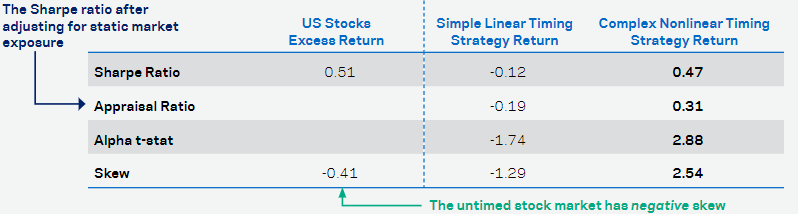

### **HML**

In [162]:
HML_predictors = predictors['1927-01-01':'2020-12-01']

In [163]:
HML_signals = rolling_signal_strategy(HML_predictors,HML,'HML Return')

100%|██████████| 1114/1114 [00:00<00:00, 1157.49it/s]


In [164]:
HML_signals

,predicted return,HML Return,strategy return
date,,,
1928-03-01,0.836232,-1.22,-1.020202
1928-04-01,-3.489270,3.44,-12.003090
1928-05-01,6.671294,-3.27,-21.815132
1928-06-01,-18.823995,-0.03,0.564720
1928-07-01,-14.392224,-0.50,7.196112
...,...,...,...
2020-08-01,-29.871638,-2.88,86.030319
2020-09-01,33.822145,-2.65,-89.628685
2020-10-01,-4.048193,4.31,-17.447711


**HML Performance Measures**

In [165]:
HML_sr = sharpe_ratio(HML_signals['HML Return'])
HML_skew = skewness(HML_signals['HML Return'])

Sharpe Ratio: 0.32463677129672786
Skewness: 2.199154120300883


**HML Simple Model Performance Measures**

In [166]:
HML_simple_sr = sharpe_ratio(HML_signals['strategy return'])
HML_simple_skew = skewness(HML_signals['strategy return'])

Sharpe Ratio: 0.11194279974056714
Skewness: 11.142586014360361


In [167]:
y = HML_signals['strategy return']
X = HML_signals['HML Return']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

alpha = model.params['const']

residuals = model.resid

tracking_error = residuals.std()

HML_simple_app_ratio  = alpha / tracking_error
HML_simple_alpha_t_stat  = model.tvalues['const']

In [168]:
data_hml = {
'HML Excess Return': [HML_sr, None, None, HML_skew],
'Simple Linear Timing Strategy Return': [
        HML_simple_sr,
        HML_simple_app_ratio,
        HML_simple_alpha_t_stat,
        HML_simple_skew
    ]
}
index_hml = ['Sharpe Ratio', 'Appraisal Ratio', 'Alpha t-stat', 'Skew']
df_hml = pd.DataFrame(data_hml, index=index_hml).style.format("{:.2f}").set_caption("Hypothetical Out-of-Sample HML Timing Performance")
df_hml

,HML Excess Return,Simple Linear Timing Strategy Return
Sharpe Ratio,0.32,0.11
Appraisal Ratio,nan,0.02
Alpha t-stat,nan,0.54
Skew,2.20,11.14


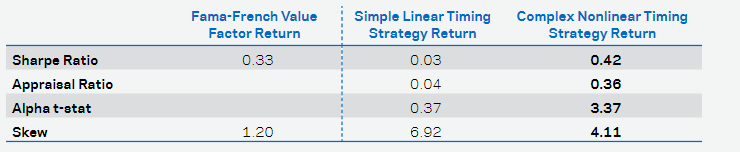